## Gestión del riesgo de un Portafolio

Seguramente ya vieron un montón de imagenes donde, sobre una distribución de pérdidas, podemos conocer cuales son nuestras pérdidas esperadas (expected losses), las pérdidas inesperadas (unexpected losses) y los famosos "cisnes negros" (black swans). Es fundamental entender bien que implican estos conceptos en el marco del diseño de una estratégia de inversión o de trading para entender correctamente cual es nuestra exposición al mercado.

Lo primero es entender ¿Qué es el riesgo? Fluctuaciones en los precios o el imcumplimiento de un deudor son eventos con los que convivimos a diario. Son eventos posibles. Esperados. Con lo cual, el riesgo corresponde a desvíos respecto a los esperado. Estos movimientos son descontados por el mercado y se descuentan en los precios. Con lo cual, el riesgo son todos los desvíos respecto a lo esperado. Muchas veces usamos como sinónimos, volatilidad, dispersión, desvíos y riesgo como sinónimos. En la jerga mucha veces lo son, pero para el armado de una estratégia tenemos que saber diferenciarlos.

Es acá donde la metodología de VaR cobra relevancia por su simplicidad y potencia. El Value at Risk nos va a decir la pérdida potencial máxima con un determinado nivel de confianza y en un plazo de tiempo determinado. La potencia del VaR es que nos arroja un valor monetario. Con lo cual, si no nosotros somos capaces de calcular cual es el desvío esperado al que nos enfrentamos y somos capaces de calcular el VaR a un determinado nivel de confianza podemos calcular (por diferencia) el capital necesario para hacer frente a pérdidas inesperadas.

Existen diversas metodologías para calcular el VaR como para calcular los requerimientos de capital. En esta notebook veremos algunas de ellas.

### Value At Risk y Backtesting

Algo interesante que podemos hacer es un backtesting de los requerimientos de capital que necesitamos para nuestra estrategia de inversión. Podemos ver por ejemplo, las veces que las pérdidas inesperadas superaron nuestro cálculo del VaR para así tener una mejor estimación de los requerimientos del capital

*Credits: https://github.com/ritvij0007/VaR_calc/blob/main/main.ipynb*

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from arch import arch_model
from scipy.stats import norm
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargamos parámetros que luego van a ser necesario para graficar
color_map = {
    'green': '#00FF00',
    'amber': '#FFBF00',
    'red': '#FF0000'
}

In [3]:
# Cargamos parámetros apra seleccionar el tipo de modelo de volatilidad
model = [
    {'vol': 'Garch', 'dist': 'normal', 'o': 0},
    {'vol': 'Garch', 'dist': 'ged', 'o': 0},
    {'vol': 'Garch', 'dist': 'normal', 'o': 1},  # GJR-GARCH
    {'vol': 'Garch', 'dist': 'ged', 'o': 1}     # GJR-GARCH
]

In [4]:
# Cargamos parámetros para seleccionar un factor de ajuste del VaR en función de las veces que nos equivocamos
var_limits = {
    "green_less_5": 1.5,
    "amber_5": 1.7,
    "amber_6": 1.76,
    "amber_7": 1.83,
    "amber_8": 1.88,
    "amber_9": 1.92,
    "red_10_or_more": 2.0
}

In [5]:
# Cargamos parámetros para seleccionar los pesos de cada activo del portafolio
portfolio_weights = np.array([50, 50])

### Introducción a la programación orientada a objetos

La programación orientada a objetos (POO) es una forma alternativa de programar evitando la programación secuencial. Con la POO podemos generar objetos que representan entidades del mundo real que hacen que nuestro código sea más prolijo y mucho más ordenado.

Una clase es una especie de mapa que nos permite definir las características (funciones, propiedades y atributos) que va a tener un objeto. En python, todo es un objeto. En cambio, una objeto es una instancia de una clase. Por otro lado, los atributos son variables que pertenecen a una clase y los métodos son funciones ¿Por qué es importante saber estos dos conceptos? Porque un objeto puede tener atributos y métodos, es decir, tener propiedades o características y hacer funciones (ej: El objeto humano puede tener manos y puede hacer la acción de caminar) Pero... que es lo importante que tenemos que saber de esto en relación a Python:

* **Método constructor**: El método __init__ se ejecuta automaticamente ni bien creamos el objeto. Como se ejecuta siempre, nos sirve para definir las características escenciales del objeto. Nosotros a una clase le podemos pasar muchos métodos (funciones) pero que no se van a ejecutar siempre. Por ejemplo: si creamos el método "calculate_returns", solo se va a ejecutar cuando nosotros lo instanciemos.
* **Self**: Es una forma de hacer referencia al propio objeto. De esta forma, podemos determinar algunas características que va a tener el objeto. Se crea siempre automáticamente y no vamos a tener que completarlo como un parámetro más aunque así parezca ¿Por qué? Porque ya entiende que estamos haciendo eso al momento de crear el objeto.
* **Métodos**: Los métodos son las funciones del objeto. Lo importante acá es que todos los métodos que creemos tienen que tener como parámetro a **self** para luego poder instanciar este método a través del objeto. De esa forma, puede autorreferenciarse.

Entonces... cuando creamos el método __init__ lo que estamos haciendo son dos cosas simultaneamente. Por un lado, creamos propiedades del objeto(self) y estamos definiendo esas propiedades pasandole parámetros al método __init__. Por ejemplo: En "self.data" estamos definiendo una propiedad de self que se va llamar data que va a ser igual al parámetro "data" que le estamos pasando.

In [6]:
# Creamos la primera clase
# Es una clase para calcular los retornos y la volatilidad dependiendo el método elegido
class FinancialMetrics:
    # Se define el método constructor donde se va a definir la data
    def __init__(self, data):
        self.data = data
        self.returns = None

    # Se define un método para calcular los retornos logarítmicos
    def calculate_returns(self):
        self.returns = np.log(self.data / self.data.shift(1)).dropna()
        return self.returns

    # Se define un método para calcular la volatilidad del portafolio. Se utiliza una ventana movil de 60 periodos.
    # Los distintos métodos que soporta son: std, ewma y garch 
    def calculate_portfolio_volatility(self, weights, method='std',
                                    models=None,
                                    rolling_window=60, lambda_value=0.94):
        # Este if se crea para corroborar que existan los retornos de los activos previamiente calculados
        if self.returns is None:
            raise ValueError("Returns have not been calculated.")

        volatilities = []

        # Hace uso de la matriz de varianzas y covarianzas
        # calcula la volatilidad del portafolio como: (weigth x Cov x weight)^(1/2)
        if method == 'std':
            for i in range(rolling_window, len(self.returns)):
                window_data = self.returns.iloc[i - rolling_window:i]
                cov_matrix = window_data.cov()
                vol = np.sqrt(np.dot(weights.T,
                                    np.dot(cov_matrix.values, weights)))
                volatilities.append(vol)

        # El lambda inicial es de 0.94 que es el factor de decaimiento que se puede setear
        elif method == 'ewma':
            # Este es un for que va desde 60 (o la ventana que elijamos de retorno) hasta los retornos totales que tengamos.
            for i in range(rolling_window, len(self.returns)):
                # Para la primer iteración esto va de 0 a 60, luego de 1 a 61 y así...
                # Nos quedamos con los primeros 60 retornos.
                window_data = self.returns.iloc[i - rolling_window:i]
                # Esto lo que hace generar el vector de ponderaciones.
                # Partimos de un vector que va de 0 a 59 (0,1,2...59) y lo multiplicamos por lambda
                # Asi tenemos ponderada toda la ventana movil.
                weights_ewma = lambda_value ** np.arange(window_data.shape[0])[::-1]
                # Divido todo ese vector por la suma de todo el vector. Entonces ahora todo el vector suma 1
                # Generamos las ponderaciones de toda la ventana movil
                weights_ewma /= weights_ewma.sum()

                # Se calculan las volatilidades bajo el supuesto que a altas frecuencias la media de los retornos es cero
                # Esto tiene varias ventajas y desventajas.
                weighted_mean1 = np.sum(
                    window_data.iloc[:, 0] ** 2 * weights_ewma) / (
                    np.sum(weights_ewma))
                weighted_mean2 = np.sum(
                    window_data.iloc[:, 1] ** 2 * weights_ewma) / (
                    np.sum(weights_ewma))

                # Calcaulamos el factor de correlación entre ambos activos
                correlation = window_data.iloc[:, 0].corr(
                    window_data.iloc[:, 1])

                # Este es el cálculo de la varianza del portafolio unicamente para dos activos.
                portfolio_variance = (weights[0] ** 2 * weighted_mean1 +
                                      weights[1] ** 2 * weighted_mean2 +
                                      2 * weights[0] * weights[1] * 
                                      np.sqrt(weighted_mean1 * weighted_mean2)
                                      * correlation)

                # Se calcula la volatilidad del portafolio
                volatilities.append(np.sqrt(portfolio_variance))

        # Cálculo de la volatilidad a partir del método Garch
        elif method == 'garch':
            # En caso de seleccionar el método garch tenemos que seleccionar un tipo de modelo
            if models is None:
                raise ValueError("Models must be provided for GARCH method.")

            # Loop que para cada uno de los modelos extraemos el tipo de volatilidad, el tipo de distribución y flag de apalancamiento
            for model_spec in tqdm(models, desc='Models'):
                vol = model_spec['vol']
                dist = model_spec['dist']
                o = model_spec['o']
                print(vol, dist, f'o={o}')

                # Acamos vamos a ir guardando als volatilidades de los distintos modelos
                portfolio_vol = []

                # Comenzamos el loop que recorra el vector de retornos con una ventana temporal movil de 60 periodos
                for i in tqdm(range(rolling_window, len(self.returns)), 
                            desc=f'{vol} {dist} o={o}', leave=False):
                    # Tramos las dos ventanas de retornos pero acá, a diferencia de arriba..un objeto por activo
                    window_returns1 = self.returns[self.returns.columns[0]][
                        i-rolling_window:i]
                    window_returns2 = self.returns[self.returns.columns[1]][
                        i-rolling_window:i]

                    # Se calcula el modelo GARCH(1,1) haciendo uso de los supuestos seleccionados
                    # Es un modelo EWMA pero con una componente adicional para la varianza de largo plazo
                    # Se hace para el activo 1
                    model1 = arch_model(window_returns1, vol=vol,
                                        p=1, o=o, q=1, dist=dist)
                    fit1 = model1.fit(disp='off')
                    cond_vol1 = fit1.conditional_volatility.iloc[-1] ** 2

                    # Se calcula el modelo GARCH(1,1) haciendo uso de los supuestos seleccionados
                    # Es un modelo EWMA pero con una componente adicional para la varianza de largo plazo
                    # Se hace para el activo 1
                    model2 = arch_model(window_returns2, vol=vol,
                                        p=1, o=o, q=1, dist=dist)
                    fit2 = model2.fit(disp='off')
                    cond_vol2 = fit2.conditional_volatility.iloc[-1] ** 2

                    # Calculamos el factor de correlacion de pearson entre activos
                    correlation = window_returns1.corr(window_returns2)

                    # Calculamos la varianza del portafolio para 1 modelo
                    portfolio_variance = (weights[0] ** 2 * cond_vol1 +
                                          weights[1] ** 2 * cond_vol2 +
                                          2 * weights[0] * weights[1] * (
                                              np.sqrt(cond_vol1 * cond_vol2)
                                              * correlation))
                    portfolio_vol.append(np.sqrt(portfolio_variance))

                # Apendeamos las volatilidades para los distintos modelos
                volatilities.append(pd.Series(portfolio_vol, 
                                            index=self.returns.index[rolling_window:]))

            # Esto se crea dado que si se selecciona el modelo GARCH el ouput (return) es distinto
            portfolio_volatility_garch_df = pd.DataFrame(
                {f"{model['vol']} {model['dist']} o={model['o']}": 
                    vol for model, vol in zip(models, volatilities)},
                index=self.returns.index[rolling_window:]
            )
    
            return portfolio_volatility_garch_df
        
        else:
            raise ValueError(f"Method {method} not recognized.")

        # Devolvemos el resultado de las volatilidades para los modelos de desvío standard y EWMA
        dates = self.returns.index[rolling_window:]
        return pd.Series(volatilities, index=dates)


In [7]:
# Definimos la segunda clase
class VaRCalculator:
    # Se define el método constructor y los distintos atributos que va a tener el resultado del VaR
    def __init__(self, data, rolling_window=60, confidence_level=0.99):
        self.data = data
        self.rolling_window = rolling_window
        self.confidence_level = confidence_level
        self.weights = portfolio_weights
        self.initial_investment = (self.weights[0] * data.iloc[0, 0]) + ((
            self.weights[1] * data.iloc[0, 1]))
        # Precio del activo por el ponderador
        self.portfolio_prices = (data * self.weights).sum(axis=1)
        self.portfolio_pnl = self.portfolio_prices.diff().dropna()

    # Definimos el VaR paramétrico. Acá tenemos que pasarle la volatilidad estimada por los distintos métodos
    def parametric_var(self, vol_data):
        # Calculamos la inversa de la función de disbtribución acumulada. Es el valor del dominió de la función de disitribución acumulada
        # Cdf es la función de distribución acumulada y tenemos que pasarle como parámetro el dominio que va de [-4,4]
        # ppf es al función de densidad de probabilidad y tenemos pasarle un dominio [-4,4] (recordar que no nos dice mucho por ser una medida relativa
        # ppf es la inversa de la función de distribución acumulada, el dominio de 
        z_score = norm.ppf(1 - self.confidence_level)

        # Esto es un diccionario (similar a un dataframe)
        var_results = {}

        # Para cada valor de la ventana temporal movil donde tenemos una volatilidad calculamos el VaR
        for col in vol_data.columns:
            portfolio_std = vol_data[col]
            var = abs(
                z_score * portfolio_std * self.portfolio_prices.shift(1))
            var_results[col] = var
        
        return pd.DataFrame(var_results)

    # Definimos el VaR por simulación histórica. Acá no es necesario una volatilidad dado que usamos la serie de retornos
    def historical_var(self):
        # Esto es una lista (similar a una serie)
        var_series = []

        # Para la venta movil de 60 períodos calculamos el percentil asociado al nivel de confianza.
        for i in range(self.rolling_window, len(self.portfolio_pnl)):
            window_data = self.portfolio_pnl.iloc[i - self.rolling_window:i]
            var = abs(
                np.percentile(
                window_data, (1 - self.confidence_level) * 100))
            var_series.append(var)

        return pd.DataFrame(var_series,
                            index=pd.to_datetime(
                                self.portfolio_pnl.index[self.rolling_window:]),
                            columns=['Historical_VaR'])

    # Definimos el VaR por simulación de montecarlo haciendo 1000 simulaciones
    def Monte_Carlo_VaR(self, num_simulations=1000):
        # Se calculan los retornos relativos de los activos
        daily_returns = self.data.pct_change().dropna()
        data = self.data
        var_series = []

        # Se hace el loop para cada rueda teniendo en cuenta una ventan temporal movil de 60 días
        for i in range(self.rolling_window, len(daily_returns)):
            today_investment = sum(data.iloc[i] * 50)
            today_weights = data.iloc[i] * 50 / today_investment
            # Se obtienen los retornos para la ventana movil
            window_data = daily_returns.iloc[i - self.rolling_window:i]
            # Se calcula la media de los activos y la covarianza
            window_mean = window_data.mean()
            window_cov = window_data.cov()

            # Se calcula la media de los retornos del portafolio
            portfolio_mean = np.dot(today_weights, window_mean)
            # Se calcula el desvío estandar del portafolio
            portfolio_std = np.sqrt(np.dot(today_weights.T,
                                        np.dot(window_cov, today_weights)))

            # Se calculan retornos aleatorios normales en función la media empirica y del desvío empírico del portafolio
            simulations = np.random.normal(
                portfolio_mean,portfolio_std,(num_simulations,1))
            # Calculamos el precio futuro del portafolio para el siguiente día
            simulated_end_values = today_investment * np.exp(simulations)
            # Se calcula el retorno del portafolio
            simulated_pnl = simulated_end_values - today_investment

            # Calculamos el VaR calculando el percentil de la distribución simulada
            var = np.percentile(simulated_pnl, (1 - self.confidence_level) * 100)
            var_series.append(abs(var))

        return pd.DataFrame(var_series, index=pd.to_datetime(
            daily_returns.index[self.rolling_window:]),
                            columns=['Monte_Carlo_VaR'])

    # Calcaulamos el backtest como las veces que el VaR menos el retorno fue menor a 0.
    # Es decir, la perdida real del día fue mayor a la pérdida potencial estimada.
    def backtest_var(self, var_df):
        exceedances = (var_df.sub(self.portfolio_pnl, axis=0) < 0).astype(int)
        exceedances_df = exceedances[-252:]
        print(exceedances_df.sum())
        return exceedances_df

    # Hacemos el plot del VaR, de los retornos, de las veces que se superó el VaR 
    def plot_exceedances(self, var_df, exceedances_df):
        portfolio_pnl = self.portfolio_pnl[-252:]
        var_df = var_df[-252:]
        for col in var_df.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(var_df.index, var_df[col], label=f'VaR - {col}', color='blue')
            plt.plot(portfolio_pnl.index,
                    portfolio_pnl, label='Portfolio P&L', color='black')
            
            exceedance_points = portfolio_pnl[exceedances_df[col] > 0]
            plt.scatter(exceedance_points.index, exceedance_points, color='red', marker='o',
                        label='Exceedances')
            
            num_exceedances = exceedance_points.shape[0]
            plt.annotate(f'Number of Exceedances: {num_exceedances}',
                        xy=(0.05, 0.95),
                        xycoords='axes fraction',
                        fontsize=12, ha='left', va='top',
                        bbox=dict(boxstyle="round,pad=0.3",
                        edgecolor='black', facecolor='white'))
            
            plt.title(f'Portfolio P&L and VaR Exceedances for {col}')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.show()


In [8]:
# Definimos la tercera clase. Esta tercera clase contiene a las otras dos clases precedentes
class VaRStatisticsCalculator:
    # Definimos el método constructor
    def __init__(self, data_path, model, rolling_window=60,
                confidence_level=0.99):
        self.data = pd.read_excel(data_path,
                                sheet_name='Data', index_col='Date')
        self.rolling_window = rolling_window
        self.confidence_level = confidence_level
        self.weights = np.array([50 * self.data.iloc[0]['AAPL'],
                                 50 * self.data.iloc[0]['MSFT']])
        self.investment = sum(self.weights)
        self.weights /= self.weights.sum()
        self.metrics = FinancialMetrics(self.data)
        self.returns = self.metrics.calculate_returns()
        self.model = model
        self.var_calculator = VaRCalculator(self.data, rolling_window,
                                            confidence_level)
        self.var_limit = var_limits
        self.color_map = color_map

    def check_data(self):
        head, tail = self.data.head(), self.data.tail()
        return head, tail
    
    # Con esta función computamos todos los VaR definidos anteriormente en un dataframe
    def calculate_var(self):
        portfolio_volatility_std = (
            self.metrics.calculate_portfolio_volatility(self.weights,
                                                        method='std'))
        portfolio_volatility_ewma = (
            self.metrics.calculate_portfolio_volatility(self.weights,
                                                        method='ewma',
                                                        lambda_value=0.94))
        portfolio_volatility_garch = (
             self.metrics.calculate_portfolio_volatility(self.weights,
                                                         method='garch',
                                                         models=self.model))
        # portfolio_volatility_garch.to_csv('garch.csv')
        
        # portfolio_volatility_garch = pd.read_csv('garch.csv', index_col='Date')
        portfolio_volatility_garch.index = pd.to_datetime(portfolio_volatility_garch.index)
        historical_var_series = self.var_calculator.historical_var()
        vols = pd.concat([portfolio_volatility_std,
                        portfolio_volatility_ewma, 
                        portfolio_volatility_garch], axis=1)
        vols.columns = ['std', 'ewma', 'garch_normal',
                        'garch_ged', 'gjr_garch_normal', 'gjr_garch_ged']
        var_df = self.var_calculator.parametric_var(vols)
        Monte_Carlo_VaR_value = self.var_calculator.Monte_Carlo_VaR(
            num_simulations=1000)
        Monte_Carlo_VaR_value.name = 'monte_carlo'
        all_model_VaR = pd.concat([var_df, historical_var_series,
                                Monte_Carlo_VaR_value],
                                axis=1)
        all_model_VaR.dropna(inplace=True)
        return all_model_VaR

    def calculate_and_plot_exceedances(self, all_model_VaR):
        exceedances_df = self.var_calculator.backtest_var(all_model_VaR)
        self.var_calculator.plot_exceedances(all_model_VaR, exceedances_df)
        self.exceedances_sum = exceedances_df.sum()
        self.last_row_var = all_model_VaR.iloc[-1, :]
        self.mean_last_60_days_var = all_model_VaR.iloc[-60:].mean()
        return self.exceedances_sum,self.last_row_var,self.mean_last_60_days_var

    # Hacemos un barplot que se va a colorear en función de la cantidad de veces que excedemos el VaR
    def plot_exceedances_with_limits(self):
        def get_color_and_limit(exceedances, var_limit):
            if exceedances < 5:
                return self.color_map['green'],var_limit['green_less_5']
            elif exceedances == 5:
                return self.color_map['amber'], var_limit['amber_5']
            elif exceedances == 6:
                return self.color_map['amber'], var_limit['amber_6']
            elif exceedances == 7:
                return self.color_map['amber'], var_limit['amber_7']
            elif exceedances == 8:
                return self.color_map['amber'], var_limit['amber_8']
            elif exceedances == 9:
                return self.color_map['amber'], var_limit['amber_9']
            else:
                return self.color_map['red'], var_limit['red_10_or_more']

        colors = []
        limit_values = []
        for col in self.exceedances_sum.index:
            exceedances = self.exceedances_sum[col]
            color, limit_value = get_color_and_limit(exceedances, self.var_limit)
            colors.append(color)
            limit_values.append(limit_value)

        # Acá vemos que es un BAR plot
        plt.figure(figsize=(12, 6))
        self.exceedances_sum.plot(kind='bar', color=colors)
        for i, (exceedances, limit_value) in enumerate(
            zip(self.exceedances_sum,limit_values)):
            plt.text(i, exceedances,
                    f'{limit_value}', ha='center', va='bottom')
        plt.title('VaR Exceedances for Different Models')
        plt.xlabel('VaR Model')
        plt.ylabel('Number of Exceedances')
        plt.ylim(0, max(self.exceedances_sum) + 1)
        plt.show()
        self.m = self.exceedances_sum.apply(
            lambda x: get_color_and_limit(x, self.var_limit)[1])
        return self.m

    # Calculamos los requerimientos de capital para cada tipo de VaR y volatilidad
    def calculate_capital_required(self):
        if not hasattr(self, 'm'):
            raise ValueError(
                "The 'm' values have not been calculated. Run 'plot_exceedances_with_limits' first.")
        # Esto se hace para la última ventana temporal de 60 días (es decir, el último VaR calculado para cada método)
        capital_required = {}
        for col in self.last_row_var.index:
            VaR_t_minus_1 = self.last_row_var[col]
            VaR_avg = self.mean_last_60_days_var[col]
            # Acá se computa el requerimiento de capital bajo esta metodología
            capital_required[col] = max(
                VaR_t_minus_1, self.m[col] * VaR_avg)
        
        capital_required_df = pd.DataFrame.from_dict(capital_required,
                                                    orient='index',
                                                    columns=['Capital_Required'])

        # Normalize the data to map the colors
        norm = mcolors.Normalize(vmin=capital_required_df['Capital_Required'].min(),
                                vmax=capital_required_df['Capital_Required'].max())
        cmap = plt.get_cmap('RdYlGn_r')
        colors = [cmap(norm(value)) for value in capital_required_df['Capital_Required']]
        print("Capital required:")
        print(capital_required_df)

        # Plot the capital required
        fig, ax = plt.subplots(figsize=(12, 6))
        bars = ax.bar(capital_required_df.index, capital_required_df['Capital_Required'],
                    color=colors)

        # Annotate the bars
        for bar, value in zip(bars, capital_required_df['Capital_Required']):
            height = bar.get_height()
            ax.annotate(f'{value:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom')

        plt.title('Capital Required for Different VaR Models')
        plt.xlabel('VaR Model')
        plt.ylabel('Capital Required')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

        return capital_required_df


### Comenzamos con los cálculo y backtest

Como conclusiones anticipadas lo que tenemos que tener en cuenta es que un VaR que tiene pocos excesos en función de los retornos observados es un VaR más conservador que otro que tenga más excesos que puede estar subestimando un poco el riesgo.

In [9]:
#file location
data_path = '../data/VaR_Capital_Charge.xlsx'
var_statistics_calculator = VaRStatisticsCalculator(data_path, model)
head,tail=var_statistics_calculator.check_data()

In [10]:
print('head of the dataframe')
head

head of the dataframe


,AAPL,MSFT
Date,,
2021-06-25,133.110001,265.019989
2021-06-28,134.779999,268.720001
2021-06-29,136.330002,271.399994
2021-06-30,136.960007,270.899994
2021-07-01,137.270004,271.600006


In [11]:
print('head of the dataframe')
tail

head of the dataframe


,AAPL,MSFT
Date,,
2024-06-17,216.669998,448.369995
2024-06-18,214.289993,446.339996
2024-06-20,209.679993,445.700012
2024-06-21,207.490005,449.779999
2024-06-24,208.139999,447.670013


In [12]:
all_model_VaR = var_statistics_calculator.calculate_var()

Models:   0%|                                                                                                                                                  | 0/4 [00:00<?, ?it/s]

Garch normal o=0



Garch normal o=0:  41%|██████████████████████████████████████████████████▉                                                                         | 284/692 [00:04<00:06, 59.90it/s]/home/lautipintos/Documentos/finance_fundamentals/env/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(

Models:  25%|██████████████████████████████████▌                                                                                                       | 1/4 [00:11<00:33, 11.12s/it]

Garch ged o=0



Garch ged o=0:   9%|███████████▎                                                                                                                    | 61/692 [00:01<00:17, 35.59it/s]/home/lautipintos/Documentos/finance_fundamentals/env/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(

Garch ged o=0:  30%|█████████████████████████████████████▊                                                                                         | 206/692 [00:07<00:22, 21.65it/s]/home/lautipintos/Documentos/finance_fundamentals/env/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(

Models:  50%|█████████████████████████████████████████████████████████████

Garch normal o=1



Garch normal o=1:   8%|█████████▌                                                                                                                   | 53/692 [00:01<00:14, 44.76it/s]/home/lautipintos/Documentos/finance_fundamentals/env/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(

Garch normal o=1:   8%|██████████▍                                                                                                                  | 58/692 [00:01<00:15, 41.07it/s]/home/lautipintos/Documentos/finance_fundamentals/env/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(

Garch normal o=1:  10%|████████████▎                                      

Garch ged o=1



Garch ged o=1:   4%|████▊                                                                                                                           | 26/692 [00:01<00:26, 24.73it/s]/home/lautipintos/Documentos/finance_fundamentals/env/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(

Garch ged o=1:   5%|██████▍                                                                                                                         | 35/692 [00:01<00:31, 20.91it/s]/home/lautipintos/Documentos/finance_fundamentals/env/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(

Garch ged o=1:   7%|█████████▍                                            

In [13]:
all_model_VaR.tail()

,std,ewma,garch_normal,garch_ged,gjr_garch_normal,gjr_garch_ged,Historical_VaR,Monte_Carlo_VaR
Date,,,,,,,,
2024-06-17,868.523343,911.638445,861.159706,892.769742,796.795460,801.059252,728.095225,789.664906
2024-06-18,887.586502,949.201366,814.225293,847.111527,837.528645,810.550981,728.095225,808.881604
2024-06-20,885.683717,921.661059,944.810193,868.978847,822.523975,820.196824,728.095225,909.022729
2024-06-21,873.668311,897.781888,928.935685,902.146464,828.408452,860.819466,728.095225,829.846658
2024-06-24,874.233973,881.853603,1106.419028,1137.483938,1036.621465,896.075720,728.095225,796.477993


std                 2
ewma                2
garch_normal        3
garch_ged           3
gjr_garch_normal    3
gjr_garch_ged       2
Historical_VaR      4
Monte_Carlo_VaR     2
dtype: int64


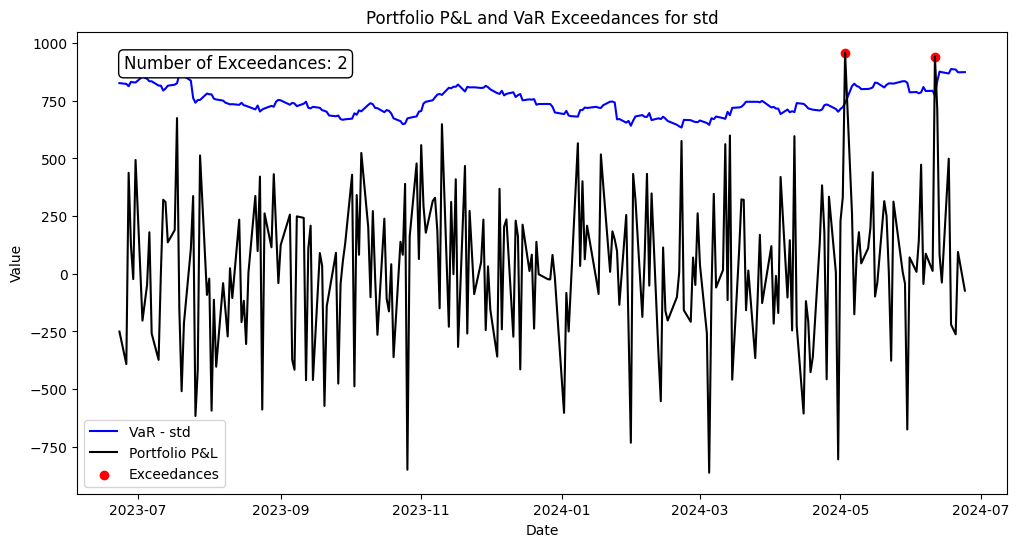

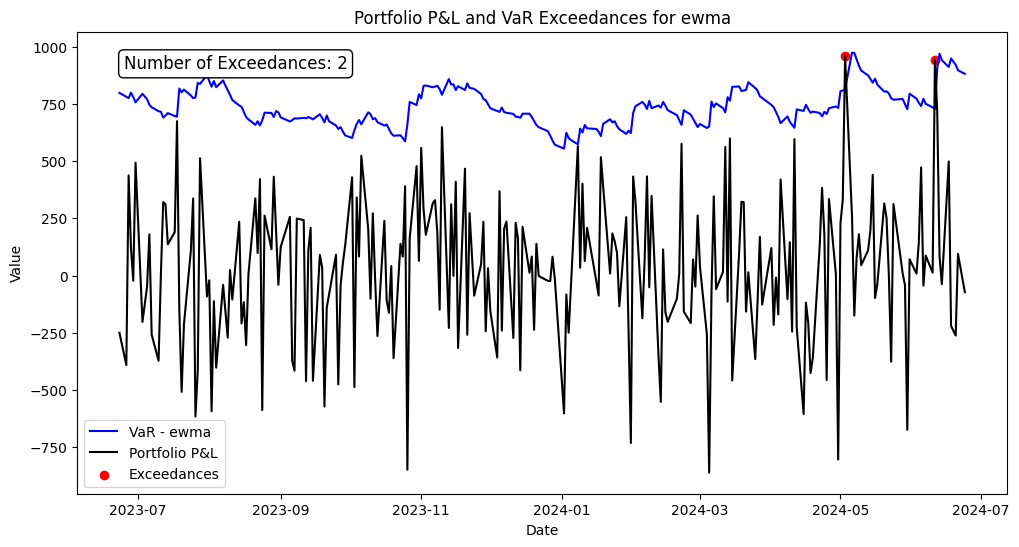

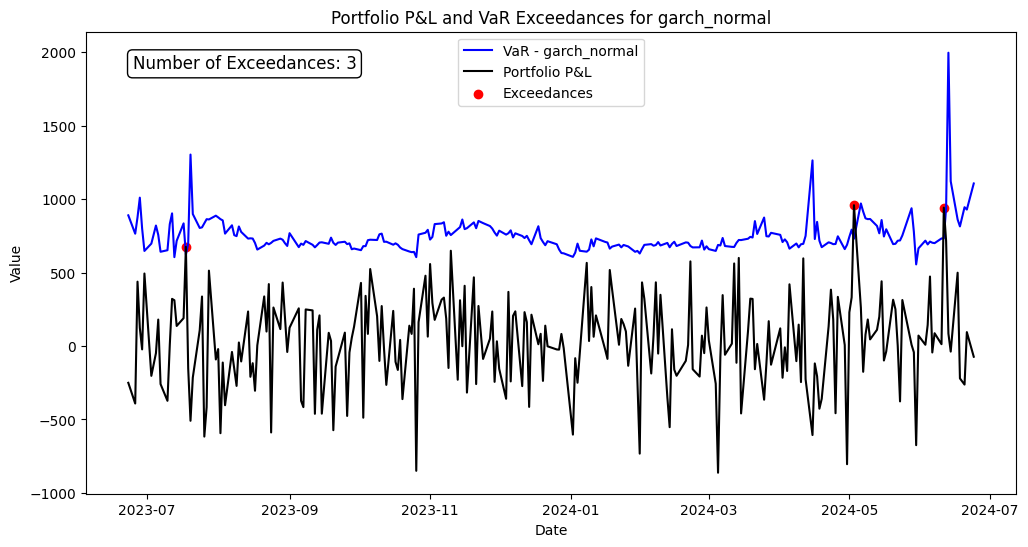

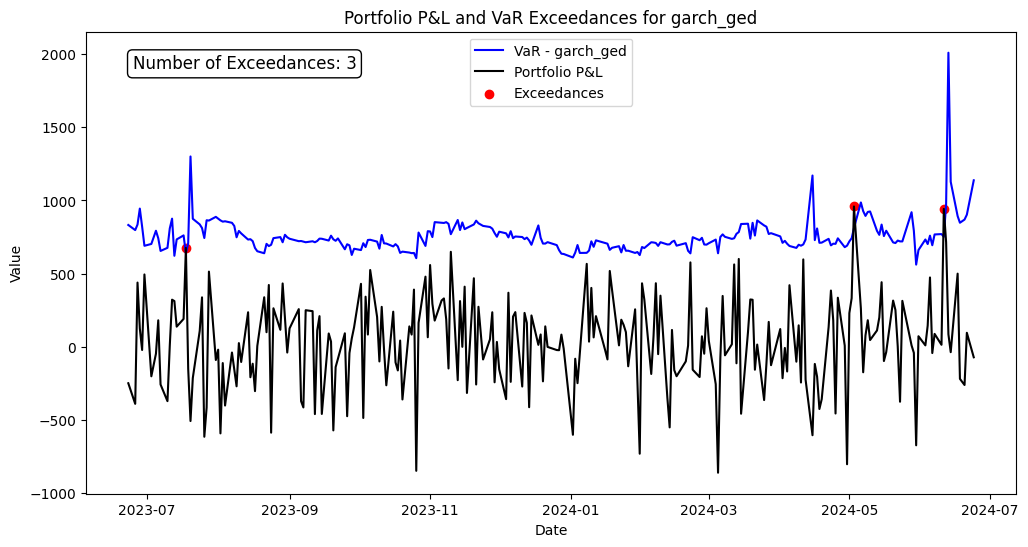

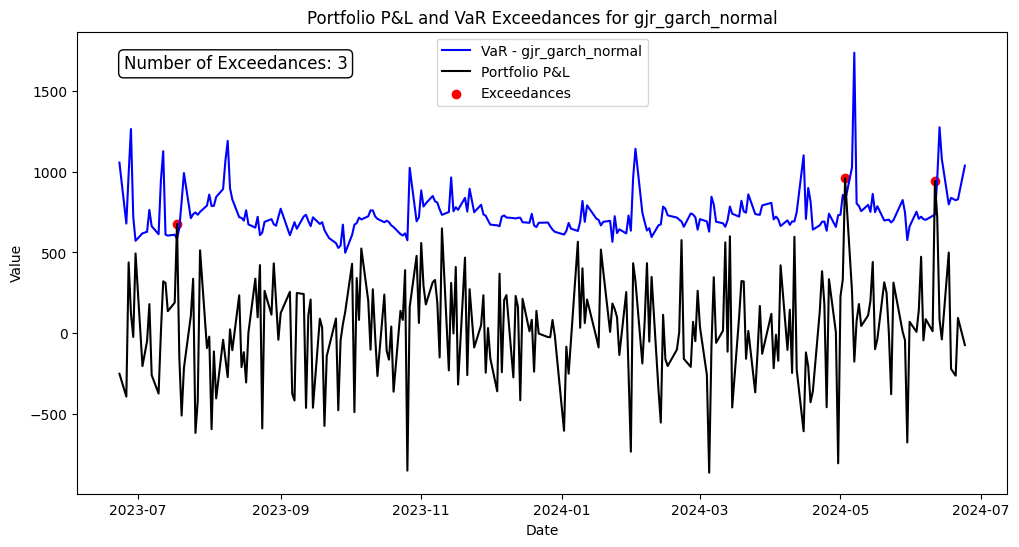

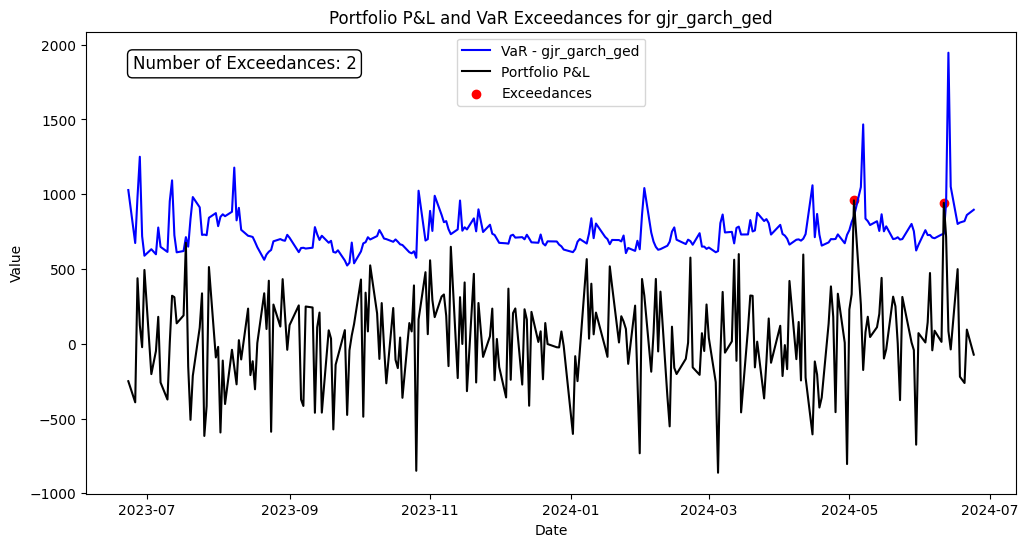

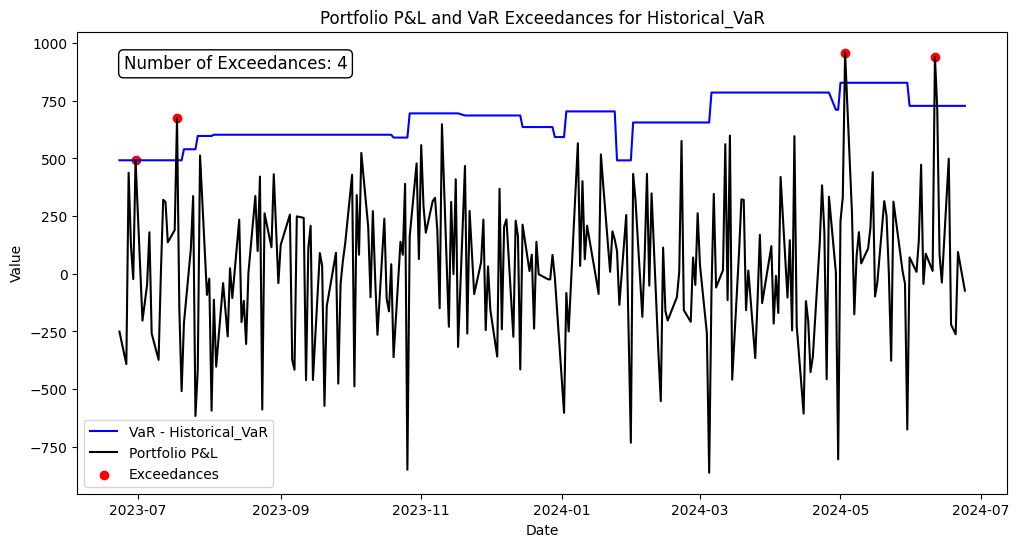

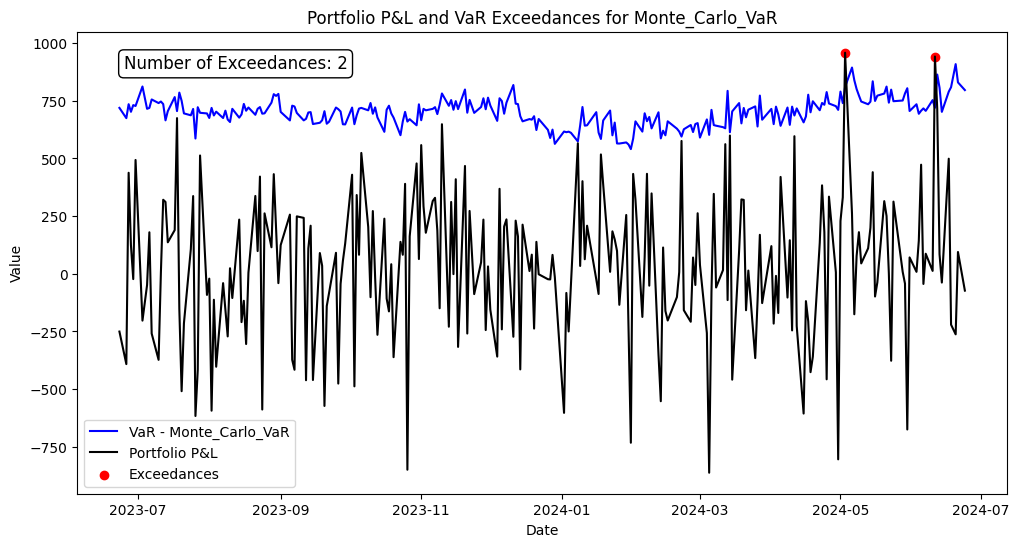

In [14]:
exceedances_sum, last_row_var, mean_last_60_days_var = (
    var_statistics_calculator.calculate_and_plot_exceedances(all_model_VaR)
)

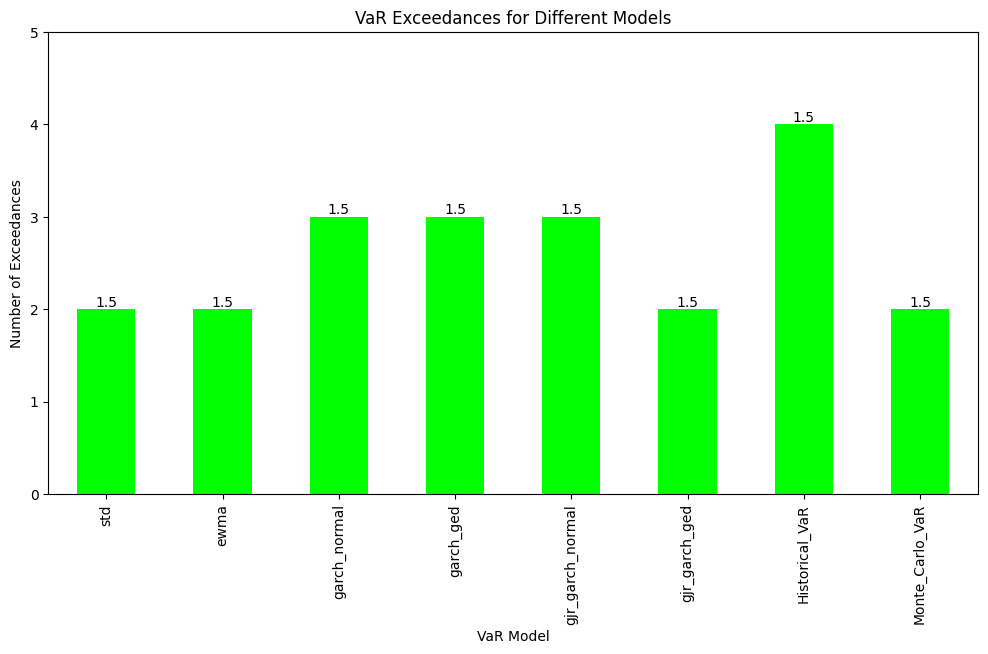

In [15]:
m_values = var_statistics_calculator.plot_exceedances_with_limits()

Capital required:
                  Capital_Required
std                    1167.928511
ewma                   1185.871109
garch_normal           1197.414166
garch_ged              1205.966518
gjr_garch_normal       1181.878520
gjr_garch_ged          1193.543072
Historical_VaR         1174.189281
Monte_Carlo_VaR        1124.755815


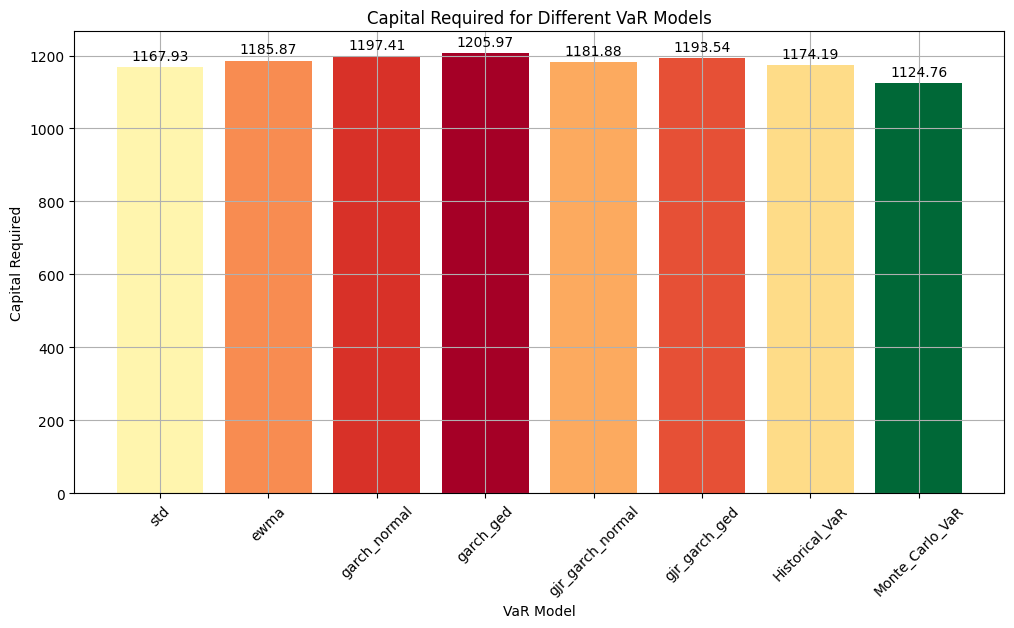

In [16]:
capital_required = var_statistics_calculator.calculate_capital_required()